# Importamos las librerias necesarias

In [190]:
import warnings
warnings.filterwarnings('ignore')

In [191]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

# Importamos el Dataset

In [192]:
df = pd.read_csv('data_cleaned.csv',encoding='latin1')

# Ingeniería de Características

Aunque ya hemos añadidos algunas columnas, vamos a añadir ahora diferentes ratios y otras variables que pueden ser utiles en el modelo:

* Ratio de cancelaciones por producto -> Product_cancel_ratio
* Ratio de cancelaciones por cliente -> Client_cancel_ratio

Vamos a crear las métricas RFM (recomendadas por FARZAD NEKOUEI en Kaggle)

* Recency: Esta metrica indica hace cuanto tiempo fue la última compra que realizó el cliente (Teniendo en cuenta las fechas del dataset)
* Frequency: Con que frecuencia hace compras el cliente
* Monetary: Tamaño medio de la cesta

## Recency

In [193]:
# Convertimos la columna InvoiceDate a datetime

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [194]:
# Convierte InvoiceDate a datetime y extrae solo la fecha
df['Day'] = df['InvoiceDate'].dt.date

# Encuentra la fecha de compra más reciente para cada cliente
datos_clientes = df.groupby('CustomerID')['Day'].max().reset_index()

# Encuentra la fecha más reciente en todo el conjunto de datos
Ultima_Compra = df['Day'].max()

# Convertimos la columna InvoiceDay a datetime
datos_clientes['Day'] = pd.to_datetime(datos_clientes['Day'])
Ultima_Compra = pd.to_datetime(Ultima_Compra)

# Calcula el número de días desde la última compra para cada cliente
datos_clientes['Dias_ultima_compra'] = (Ultima_Compra - datos_clientes['Day']).dt.days

# Elimina la columna InvoiceDay
datos_clientes.drop(columns=['Day'], inplace=True)


## Frequency

Para esta parte necesitamos las transacciones totales realizadas por un cliente, es decir el numero de transacciones por CustomerID y el total de productos comprados por cada cliente, es decir, la suma de las QUantity

In [195]:
# Calculamos la frecuencia de compra de cada cliente

frecuencia_compra = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frecuencia_compra.rename(columns={'InvoiceNo': 'ComprasTotales'}, inplace=True)

# Calculamos el numero total de productos comprados por cada cliente

productos_totales_comprados = df.groupby('CustomerID')['Quantity'].sum().reset_index()
productos_totales_comprados.rename(columns={'Quantity': 'ProductosTotalesComprados'}, inplace=True)

# Combinamos estas nuevas variables en el dataframe datos_clientes

datos_clientes = datos_clientes.merge(frecuencia_compra, on='CustomerID')
datos_clientes = datos_clientes.merge(productos_totales_comprados, on='CustomerID')

# Mostramos las 5 primeras entradas

datos_clientes.head()

,CustomerID,Dias_ultima_compra,ComprasTotales,ProductosTotalesComprados
0,12347.0,2,7,2458
1,12348.0,75,4,2332
2,12349.0,18,1,630
3,12350.0,310,1,196
4,12352.0,36,8,463


## Monetary

Para este apartado necesitaremos calcular el total gastado por el cliente (Ya lo tenemos en ClientTotalSales) y la media de valor de la cesta de compra de cada cliente

In [196]:
# Creamos la columna Cesta_media diviendo df.ClientTotalSales entre datos_clientes.ComprasTotales y lo añadimos a datos_clientes

datos_clientes['CestaMedia'] = df['ClientTotalSales'] / datos_clientes['ComprasTotales']

In [197]:
datos_clientes.head()

,CustomerID,Dias_ultima_compra,ComprasTotales,ProductosTotalesComprados,CestaMedia
0,12347.0,2,7,2458,770.172857
1,12348.0,75,4,2332,1347.802500
2,12349.0,18,1,630,5391.210000
3,12350.0,310,1,196,5391.210000
4,12352.0,36,8,463,673.901250


## Ratios cancelacion

In [198]:
# Calculamos el total de productos vendidos por StockCode
total_sales = df[df['Status'] == 'COMPLETED'].groupby('StockCode')['Quantity'].sum().reset_index()
total_sales.rename(columns={'Quantity': 'ProductTotalSales_uf'}, inplace=True)

# Calculamos el total de productos cancelados por StockCode
total_cancels = df[df['Status'] == 'CANCEL'].groupby('StockCode')['Quantity'].sum().abs().reset_index()
total_cancels.rename(columns={'Quantity': 'ProductTotalCancel_uf'}, inplace=True)

# Hacemos merge con el DataFrame original para añadir los totales de ventas y cancelaciones
df = df.merge(total_sales, on='StockCode', how='left')
df = df.merge(total_cancels, on='StockCode', how='left')

# Rellenamos los NaN con 0 en caso de que no haya ventas o cancelaciones para algunos StockCodes
df['ProductTotalSales_uf'].fillna(0, inplace=True)
df['ProductTotalCancel_uf'].fillna(0, inplace=True)

# Calculamos el ratio de cancelaciones en unidades físicas
df['ProductCancelRatio_uf'] = (df['ProductTotalCancel_uf'] / df['ProductTotalSales_uf']).fillna(0) * 100



In [199]:
# Para calcular el ratio de cancelaciones en unidades monetarias, vamos a eliminar las columnas existentes y vamos a recrearlas de nuevo siguiendo el mismo sistema

# Eliminamos las columnas si ya existen
columns_to_remove = ['ProductTotalSales', 'ProductTotalCancel', 'ProductTotalNet']
df = df.drop(columns=columns_to_remove, errors='ignore')

# Calculamos el total de ventas en términos monetarios por StockCode
total_sales_money = df[df['Status'] == 'COMPLETED'].groupby('StockCode').apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum()).reset_index()
total_sales_money.rename(columns={0: 'ProductTotalSales'}, inplace=True)

# Calculamos el total de cancelaciones en términos monetarios por StockCode
total_cancels_money = df[df['Status'] == 'CANCEL'].groupby('StockCode').apply(lambda x: (x['Quantity'] * x['UnitPrice']).sum()).abs().reset_index()
total_cancels_money.rename(columns={0: 'ProductTotalCancel'}, inplace=True)

# Hacemos merge con el DataFrame original
df = df.merge(total_sales_money, on='StockCode', how='left')
df = df.merge(total_cancels_money, on='StockCode', how='left')

# Rellenamos los NaN con 0
df['ProductTotalSales'].fillna(0, inplace=True)
df['ProductTotalCancel'].fillna(0, inplace=True)

# Calculamos la columna ProductTotalNet
df['ProductTotalNet'] = df['ProductTotalSales'] - df['ProductTotalCancel']

Seguiremos el proceso similar para calcular los ratios y metricas por cliente

In [200]:
# Eliminamos las columnas si ya existen
columns_to_remove = ['ClientTotalSales', 'ClientTotalCancel', 'ClientTotalSales_uf', 'ClientTotalCancel_uf', 'ClientCancelRatio_uf']
df = df.drop(columns=columns_to_remove, errors='ignore')

# Calculamos ClientTotalSales y ClientTotalCancel en términos monetarios
client_total_sales = df[df['Status'] == 'COMPLETED'].groupby('CustomerID')['TotalInvoice'].sum().reset_index()
client_total_sales.rename(columns={'TotalInvoice': 'ClientTotalSales'}, inplace=True)

client_total_cancels = df[df['Status'] == 'CANCEL'].groupby('CustomerID')['TotalInvoice'].sum().abs().reset_index()
client_total_cancels.rename(columns={'TotalInvoice': 'ClientTotalCancel'}, inplace=True)

# Calculamos ClientTotalSales_uf y ClientTotalCancel_uf en unidades físicas
client_total_sales_uf = df[df['Status'] == 'COMPLETED'].groupby('CustomerID')['Quantity'].sum().reset_index()
client_total_sales_uf.rename(columns={'Quantity': 'ClientTotalSales_uf'}, inplace=True)

client_total_cancels_uf = df[df['Status'] == 'CANCEL'].groupby('CustomerID')['Quantity'].sum().abs().reset_index()
client_total_cancels_uf.rename(columns={'Quantity': 'ClientTotalCancel_uf'}, inplace=True)

# Hacemos merge con el DataFrame original
df = df.merge(client_total_sales, on='CustomerID', how='left')
df = df.merge(client_total_cancels, on='CustomerID', how='left')
df = df.merge(client_total_sales_uf, on='CustomerID', how='left')
df = df.merge(client_total_cancels_uf, on='CustomerID', how='left')

# Rellenamos los NaN con 0
df.fillna({'ClientTotalSales': 0, 'ClientTotalCancel': 0, 'ClientTotalSales_uf': 0, 'ClientTotalCancel_uf': 0}, inplace=True)

# Calculamos el ratio de cancelaciones en unidades físicas
df['ClientCancelRatio_uf'] = (df['ClientTotalCancel_uf'] / df['ClientTotalSales_uf']).fillna(0) * 100


In [201]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,TotalLine,...,ProductTotalCancel_uf,ProductCancelRatio_uf,ProductTotalSales,ProductTotalCancel,ProductTotalNet,ClientTotalSales,ClientTotalCancel,ClientTotalSales_uf,ClientTotalCancel_uf,ClientCancelRatio_uf
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,COMPLETED,15.30,...,2578.0,7.012485,100547.45,6624.30,93923.15,81793.19,1052.76,1733.0,37.0,2.135026
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,COMPLETED,20.34,...,39.0,2.388242,5893.45,139.77,5753.68,81793.19,1052.76,1733.0,37.0,2.135026
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,COMPLETED,22.00,...,42.0,2.190923,7121.23,162.50,6958.73,81793.19,1052.76,1733.0,37.0,2.135026
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,COMPLETED,20.34,...,14.0,0.567951,9313.17,58.00,9255.17,81793.19,1052.76,1733.0,37.0,2.135026
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,COMPLETED,20.34,...,19.0,0.516866,13311.26,76.45,13234.81,81793.19,1052.76,1733.0,37.0,2.135026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399562,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680.0,France,COMPLETED,10.20,...,10.0,0.672043,1150.38,8.50,1141.88,12042.65,0.00,439.0,0.0,0.000000
399563,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680.0,France,COMPLETED,12.60,...,5.0,0.252398,3984.78,10.50,3974.28,12042.65,0.00,439.0,0.0,0.000000
399564,581587,23254,childrens cutlery dolly girl,4,2011-12-09 12:50:00,4.15,12680.0,France,COMPLETED,16.60,...,20.0,1.207001,6674.95,83.00,6591.95,12042.65,0.00,439.0,0.0,0.000000
399565,581587,23255,childrens cutlery circus parade,4,2011-12-09 12:50:00,4.15,12680.0,France,COMPLETED,16.60,...,9.0,0.935551,3852.44,37.35,3815.09,12042.65,0.00,439.0,0.0,0.000000


De FARZAD NEKOUEI encontramos otras características interesantes como la diversidad de productos, dias medios entre compras, dia de compras favorito, hora de compra favorita.

## Diversidad

In [202]:
# Calculamos el número de productos únicos comprados por cada cliente
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'ProductosUnicosComprados'}, inplace=True)


# Combina el nuevo feature en el dataframe customer_data
datos_clientes = pd.merge(datos_clientes, unique_products_purchased, on='CustomerID')

# Muestra las primeras filas del dataframe customer_data
datos_clientes.head()

,CustomerID,Dias_ultima_compra,ComprasTotales,ProductosTotalesComprados,CestaMedia,ProductosUnicosComprados
0,12347.0,2,7,2458,770.172857,103
1,12348.0,75,4,2332,1347.802500,21
2,12349.0,18,1,630,5391.210000,72
3,12350.0,310,1,196,5391.210000,16
4,12352.0,36,8,463,673.901250,57


## Variables de comportamiento

In [203]:
# Extraemos el día de la semana y la hora de InvoiceDate

df['Dia_Semana'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculamos el número medio de días entre compras para cada cliente

dias_entre_compras = df.groupby('CustomerID')['Day'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
media_dias_entre_compras = dias_entre_compras.groupby('CustomerID').mean().reset_index()
media_dias_entre_compras.rename(columns={'Day': 'media_dias_entre_compras'}, inplace=True)

# Encontramos el día favorito de la semana para cada cliente

dia_favorito = df.groupby(['CustomerID', 'Dia_Semana']).size().reset_index(name='Count')
dia_favorito = dia_favorito.loc[dia_favorito.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Dia_Semana']]


# Encontramos la hora favorita del día para cada cliente

hora_favorita = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
hora_favorita = hora_favorita.loc[hora_favorita.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Combinamos los nuevos features en el dataframe customer_data
datos_clientes = pd.merge(datos_clientes, media_dias_entre_compras, on='CustomerID')
datos_clientes = pd.merge(datos_clientes, dia_favorito, on='CustomerID')
datos_clientes = pd.merge(datos_clientes, hora_favorita, on='CustomerID')

datos_clientes.head()



,CustomerID,Dias_ultima_compra,ComprasTotales,ProductosTotalesComprados,CestaMedia,ProductosUnicosComprados,media_dias_entre_compras,Dia_Semana,Hour
0,12347.0,2,7,2458,770.172857,103,2.016575,1,14
1,12348.0,75,4,2332,1347.802500,21,10.884615,3,19
2,12349.0,18,1,630,5391.210000,72,0.000000,0,9
3,12350.0,310,1,196,5391.210000,16,0.000000,2,16
4,12352.0,36,8,463,673.901250,57,3.132530,1,14


## Tendencias y estacionalidad (FARZAD NEKOUEI)

Farzad añade las columnas de Media de gasto mensual, variacion de gasto mensual, tendencia de gasto

In [204]:

# Extraemos el mes y el año de InvoiceDate

df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculamos el gasto mensual para cada cliente

gasto_mensual = df.groupby(['CustomerID', 'Year', 'Month'])['TotalLine'].sum().reset_index()


# Calculo estacional de patrones de compra: estamos utilizando la frecuencia mensual como un proxy para los patrones de compra estacionales

patrones_compra_estacional = gasto_mensual.groupby('CustomerID')['TotalLine'].agg(['mean', 'std']).reset_index()
patrones_compra_estacional.rename(columns={'mean': 'Media_Gasto_Mensual', 'std': 'Desviacion_Gasto_Mensual'}, inplace=True)

# Reemplazamos los valores NaN en Monthly_Spending_Std con 0, lo que implica que no hay variabilidad para

patrones_compra_estacional['Desviacion_Gasto_Mensual'].fillna(0, inplace=True)


# Calculamos la tendencia de gasto para cada cliente

# Estamos usando un modelo de regresión lineal simple para calcular la tendencia de gasto para cada cliente
def calculate_trend(datos_gasto):
    
    # Si hay más de un punto de datos, calculamos la tendencia utilizando la regresión lineal
    if len(datos_gasto) > 1:
        x = np.arange(len(datos_gasto))
        slope, _, _, _, _ = linregress(x, datos_gasto)
        return slope
    
    # Si solo hay un punto de datos, no se puede calcular la tendencia, por lo que devolvemos 0
    else:
        return 0


# Aplicamos la función calculate_trend para encontrar la tendencia de gasto para cada cliente
tendencia_gasto = gasto_mensual.groupby('CustomerID')['TotalLine'].apply(calculate_trend).reset_index()
tendencia_gasto.rename(columns={'TotalLine': 'Tendencia_Gasto'}, inplace=True)


# Combinamos los nuevos features en el dataframe customer_data
datos_clientes = pd.merge(datos_clientes, patrones_compra_estacional, on='CustomerID')
datos_clientes = pd.merge(datos_clientes, tendencia_gasto, on='CustomerID')

# Display the first few rows of the customer_data dataframe
datos_clientes.head()

,CustomerID,Dias_ultima_compra,ComprasTotales,ProductosTotalesComprados,CestaMedia,ProductosUnicosComprados,media_dias_entre_compras,Dia_Semana,Hour,Media_Gasto_Mensual,Desviacion_Gasto_Mensual,Tendencia_Gasto
0,12347.0,2,7,2458,770.172857,103,2.016575,1,14,615.714286,341.070789,4.486071
1,12348.0,75,4,2332,1347.802500,21,10.884615,3,19,359.310000,203.875689,-100.884000
2,12349.0,18,1,630,5391.210000,72,0.000000,0,9,1457.550000,0.000000,0.000000
3,12350.0,310,1,196,5391.210000,16,0.000000,2,16,294.400000,0.000000,0.000000
4,12352.0,36,8,463,673.901250,57,3.132530,1,14,316.352500,134.700629,9.351000


In [205]:
# Convertimos CustomerID a string

datos_clientes['CustomerID'] = datos_clientes['CustomerID'].astype(str)

# Convertimos los datos a tipos optimos
customer_data = datos_clientes.convert_dtypes()

datos_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4281 entries, 0 to 4280
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 4281 non-null   object 
 1   Dias_ultima_compra         4281 non-null   int64  
 2   ComprasTotales             4281 non-null   int64  
 3   ProductosTotalesComprados  4281 non-null   int64  
 4   CestaMedia                 4281 non-null   float64
 5   ProductosUnicosComprados   4281 non-null   int64  
 6   media_dias_entre_compras   4281 non-null   float64
 7   Dia_Semana                 4281 non-null   int32  
 8   Hour                       4281 non-null   int32  
 9   Media_Gasto_Mensual        4281 non-null   float64
 10  Desviacion_Gasto_Mensual   4281 non-null   float64
 11  Tendencia_Gasto            4281 non-null   float64
dtypes: float64(5), int32(2), int64(4), object(1)
memory usage: 368.0+ KB


Antes de eliminar los Outliers, vamos a añadir las variables que faltan a Datos_clientes

In [206]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Status', 'TotalLine',
       'TotalInvoice', 'Day', 'ProductTotalSales_uf', 'ProductTotalCancel_uf',
       'ProductCancelRatio_uf', 'ProductTotalSales', 'ProductTotalCancel',
       'ProductTotalNet', 'ClientTotalSales', 'ClientTotalCancel',
       'ClientTotalSales_uf', 'ClientTotalCancel_uf', 'ClientCancelRatio_uf',
       'Dia_Semana', 'Hour', 'Year', 'Month'],
      dtype='object')

In [207]:
# Asegurarse de que CustomerID es del mismo tipo en ambos DataFrames
df['CustomerID'] = df['CustomerID'].astype(str) # Convertir a string si es necesario
datos_clientes['CustomerID'] = datos_clientes['CustomerID'].astype(str) # Convertir a string

# Agrupar por CustomerID en df y obtener el primer valor de cada grupo
customer_metrics = df.groupby('CustomerID').agg({
    'ClientTotalSales': 'first',
    'ClientTotalCancel': 'first',
    'ClientTotalSales_uf': 'first',
    'ClientTotalCancel_uf': 'first',
    'ClientCancelRatio_uf': 'first'
}).reset_index()

# Hacer merge con datos_clientes
datos_clientes = datos_clientes.merge(customer_metrics, on='CustomerID', how='left')

# Reemplazar los valores nulos con 0
datos_clientes.fillna(0, inplace=True)


datos_clientes.head()


,CustomerID,Dias_ultima_compra,ComprasTotales,ProductosTotalesComprados,CestaMedia,ProductosUnicosComprados,media_dias_entre_compras,Dia_Semana,Hour,Media_Gasto_Mensual,Desviacion_Gasto_Mensual,Tendencia_Gasto,ClientTotalSales,ClientTotalCancel,ClientTotalSales_uf,ClientTotalCancel_uf,ClientCancelRatio_uf
0,12347.0,2,7,2458,770.172857,103,2.016575,1,14,615.714286,341.070789,4.486071,134181.24,0.00,2458.0,0.0,0.000000
1,12348.0,75,4,2332,1347.802500,21,10.884615,3,19,359.310000,203.875689,-100.884000,17510.00,0.00,2332.0,0.0,0.000000
2,12349.0,18,1,630,5391.210000,72,0.000000,0,9,1457.550000,0.000000,0.000000,126543.60,0.00,630.0,0.0,0.000000
3,12350.0,310,1,196,5391.210000,16,0.000000,2,16,294.400000,0.000000,0.000000,5350.40,0.00,196.0,0.0,0.000000
4,12352.0,36,8,463,673.901250,57,3.132530,1,14,316.352500,134.700629,9.351000,21041.24,842.31,526.0,63.0,11.977186


In [208]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,TotalLine,...,ProductTotalNet,ClientTotalSales,ClientTotalCancel,ClientTotalSales_uf,ClientTotalCancel_uf,ClientCancelRatio_uf,Dia_Semana,Hour,Year,Month
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,COMPLETED,15.30,...,93923.15,81793.19,1052.76,1733.0,37.0,2.135026,2,8,2010,12
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,COMPLETED,20.34,...,5753.68,81793.19,1052.76,1733.0,37.0,2.135026,2,8,2010,12
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,COMPLETED,22.00,...,6958.73,81793.19,1052.76,1733.0,37.0,2.135026,2,8,2010,12
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,COMPLETED,20.34,...,9255.17,81793.19,1052.76,1733.0,37.0,2.135026,2,8,2010,12
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,COMPLETED,20.34,...,13234.81,81793.19,1052.76,1733.0,37.0,2.135026,2,8,2010,12


Veamos cuales han sido estas nuevas columnas de clientes:

* Dias_ultima_compra: Cuantos días han pasado desde que realizó la última compra
* ComprasTotales: Numero total de compras realizadas por el usuario
* ProductosTotalesComprados: Numero de productos comprados totales
* CestaMedia: Valor medio de la cesta
* ProductosUnicosComprados: Cantidad de productos diferentes comprados
* media_dias_entre_compras: El promedio de dias que pasan de una compra a otra
* Dia_Semana: El día favorito de compra del cliente
* Hour: Hora favorita de compra
* Media_Gasto_Mensual: Gasto medio mensual del cliente
* Desviacion_Gasto_Mensual: La desvición estandar del gasto mensual indicando la variabilidad de su patron
* Tendencia_Gasto: Una representación del gasto del cliente durante el tiempo. Un valor positivo indica una tendencia creciente, un valor negativo indica una tendencia decreciente, un valor cercano a 0 indica una tendencia estable.

# Análisis de Outliers

Aprovechando que hemos cogido estas nuevas variables de FARZAD, el mismo realiza un análisis de outliers a la tabla creada y luego los elimina del dataset principal. Me gustó bastante el método así que aprovecho para probarlo aquí.

In [209]:
datos_clientes.replace([np.inf, -np.inf], 0, inplace=True)

In [210]:
# Inicializamos el modelo IsolationForest con un parámetro de contaminación de 0.05 y Random_state de 42
# Esto significa que esperamos que el 3% de las observaciones sean outliers 

model = IsolationForest(contamination=0.03, random_state=42)


# Entrene el modelo en nuestro conjunto de datos (convierta DataFrame a NumPy para evitar advertencias)
datos_clientes['Outlier_Scores'] = model.fit_predict(datos_clientes.iloc[:, 1:].to_numpy())


# Creamos una nueva columna para identificar los outliers (1 para inliers y -1 para outliers)
datos_clientes['Is_Outlier'] = [1 if x == -1 else 0 for x in datos_clientes['Outlier_Scores']]


# Mostramos las primeras filas del dataframe customer_data
datos_clientes.head()

,CustomerID,Dias_ultima_compra,ComprasTotales,ProductosTotalesComprados,CestaMedia,ProductosUnicosComprados,media_dias_entre_compras,Dia_Semana,Hour,Media_Gasto_Mensual,Desviacion_Gasto_Mensual,Tendencia_Gasto,ClientTotalSales,ClientTotalCancel,ClientTotalSales_uf,ClientTotalCancel_uf,ClientCancelRatio_uf,Outlier_Scores,Is_Outlier
0,12347.0,2,7,2458,770.172857,103,2.016575,1,14,615.714286,341.070789,4.486071,134181.24,0.00,2458.0,0.0,0.000000,1,0
1,12348.0,75,4,2332,1347.802500,21,10.884615,3,19,359.310000,203.875689,-100.884000,17510.00,0.00,2332.0,0.0,0.000000,1,0
2,12349.0,18,1,630,5391.210000,72,0.000000,0,9,1457.550000,0.000000,0.000000,126543.60,0.00,630.0,0.0,0.000000,1,0
3,12350.0,310,1,196,5391.210000,16,0.000000,2,16,294.400000,0.000000,0.000000,5350.40,0.00,196.0,0.0,0.000000,1,0
4,12352.0,36,8,463,673.901250,57,3.132530,1,14,316.352500,134.700629,9.351000,21041.24,842.31,526.0,63.0,11.977186,1,0


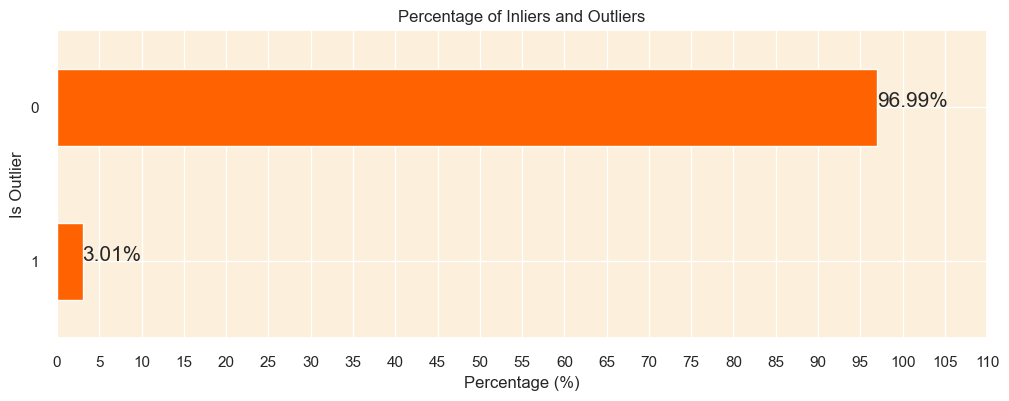

In [211]:
# Calculamos el porcentaje de inliers y outliers
porcentaje_outliers = datos_clientes['Is_Outlier'].value_counts(normalize=True) * 100


# Grafico de porcentaje de inliers y outliers
plt.figure(figsize=(12, 4))
porcentaje_outliers.plot(kind='barh', color='#ff6200')


# Añadiendo las etiquetas de porcentaje en las barras
for index, value in enumerate(porcentaje_outliers):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [212]:

# Separamos los outliers para su análisis
datos_outliers = datos_clientes[datos_clientes['Is_Outlier'] == 1]


# Elimina los outliers del conjunto de datos principal
datos_clientes_limpio = datos_clientes[datos_clientes['Is_Outlier'] == 0]


# Elimina las columnas 'Outlier_Scores' y 'Is_Outlier'
datos_clientes_limpio = datos_clientes_limpio.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reseteamos el índice del conjunto de datos limpio
datos_clientes_limpio.reset_index(drop=True, inplace=True)

In [213]:
# Obtener el número de filas en el conjunto de datos de clientes limpio
datos_clientes_limpio.shape[0]

4152

Hemos limpiado el 3% de los clientes, asumiendo que son Outliers. Podríamos haber usado otros métodos de seleccionar Outliers, pero en este caso he querido probar con este método. Quedan 4152 clientes.

## Análisis de correlación

En esta fase vamos a estudiar las correlaciones y analizar la tabla de clientes.

In [214]:
# Eliminar columna ProductosTotalesComprados ya que estaba duplicada

datos_clientes_limpio = datos_clientes_limpio.drop(columns=['ProductosTotalesComprados'])

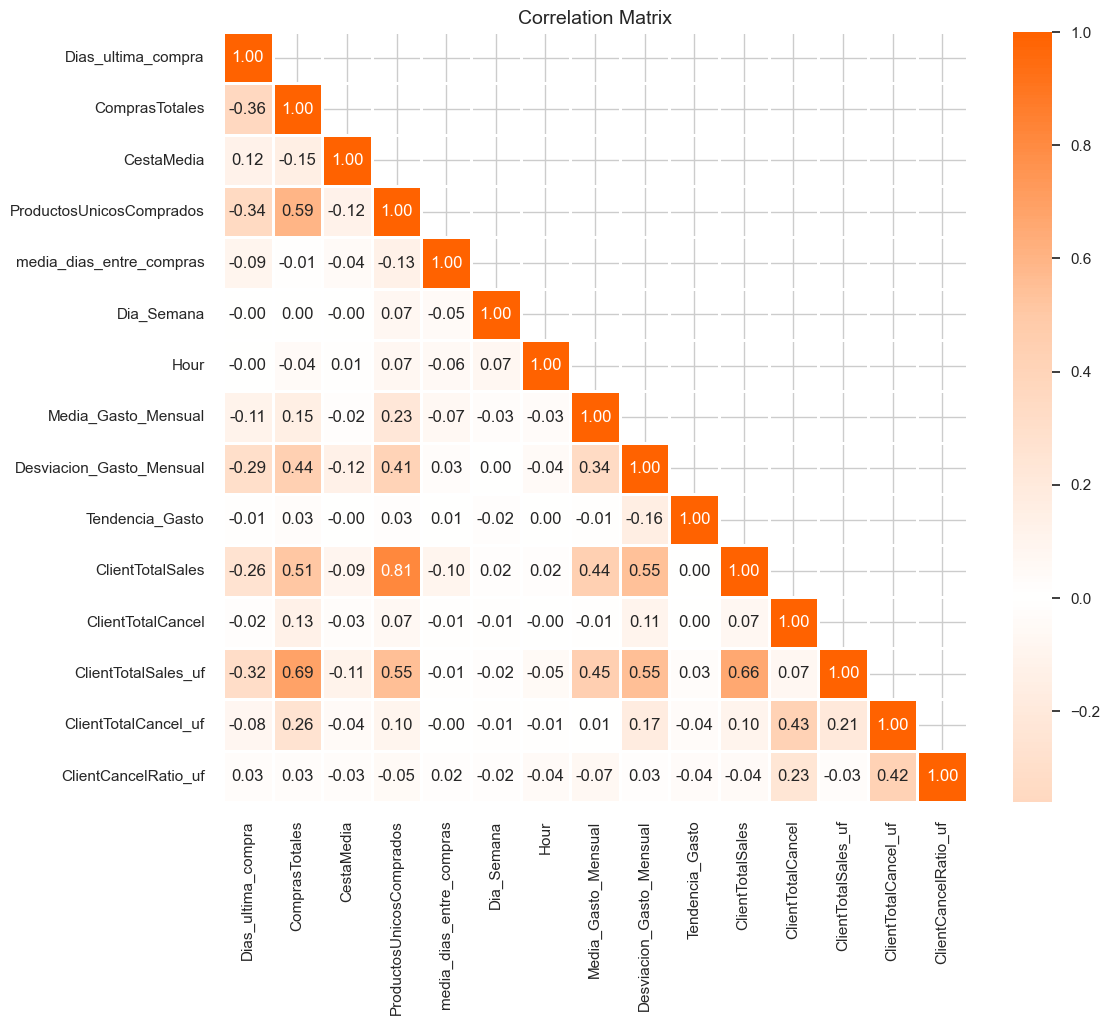

In [215]:

# Reseteamos el estilo de fondo
sns.set_style('whitegrid')

# Calculamos la matriz de correlación excluyendo la columna 'CustomerID'
corr = datos_clientes_limpio.drop(columns=['CustomerID']).corr()


# Definiendo un mapa de colores personalizado
colores = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colores, N=256)


# Creamos una máscara para mostrar solo el triángulo inferior de la matriz de correlación
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Pintamos el mapa
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

Observando el mapa de correlaciones, podemos ver algun par de variables con alta correlación, algunas bastante lógicas:

* Compras totales con dias desde la ultima compra. A mas días, menos compras. Sucede igual con productos totales comprados
* Productos comprados y Productos unicos comprados con compras totales
* Vemos que ClienTotalSales_uf correlaciona con la media gasto mensual y su desviacion
* Ratio de cancelacion con cancelaciones totales


# Estandarización

Vamos a estandarizar los datos, menos CustomerID, y Dia_Semana

In [216]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Dia_Semana']

# List of columns that need to be scaled
columns_to_scale = datos_clientes_limpio.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
datos_clientes_escalado = datos_clientes_limpio.copy()

# Applying the scaler to the necessary columns in the dataset
datos_clientes_escalado[columns_to_scale] = scaler.fit_transform(datos_clientes_escalado[columns_to_scale])

# Display the first few rows of the scaled data
datos_clientes_escalado.head()

,CustomerID,Dias_ultima_compra,ComprasTotales,CestaMedia,ProductosUnicosComprados,media_dias_entre_compras,Dia_Semana,Hour,Media_Gasto_Mensual,Desviacion_Gasto_Mensual,Tendencia_Gasto,ClientTotalSales,ClientTotalCancel,ClientTotalSales_uf,ClientTotalCancel_uf,ClientCancelRatio_uf
0,12347.0,-0.896098,0.535989,-0.249061,0.715258,-0.124037,1,0.648630,0.616183,1.124328,0.110332,1.503238,-0.122381,1.621589,-0.228657,-0.170764
1,12348.0,-0.159995,-0.065099,-0.188560,-0.569020,0.646271,3,2.812814,-0.043725,0.390563,-0.467451,-0.294322,-0.122381,1.501928,-0.228657,-0.170764
2,12349.0,-0.734761,-0.666186,0.234950,0.229738,-0.299203,0,-1.515555,2.782814,-0.699831,0.085734,1.385565,-0.122381,-0.114441,-0.228657,-0.170764
3,12350.0,2.209654,-0.666186,0.234950,-0.647329,-0.299203,2,1.514304,-0.210784,-0.699831,0.085734,-0.481666,-0.122381,-0.526606,-0.228657,-0.170764
4,12352.0,-0.553256,0.736352,-0.259145,-0.005190,-0.027101,1,0.648630,-0.154284,0.020593,0.137009,-0.239916,1.009421,-0.213209,1.542316,1.272321


# Reduccion de dimensionalidad

Vamos a aplicar PCA para disminuir la dimensionalidad, esto mejorará el clustering, evitando que se diluya demasiado la informacion

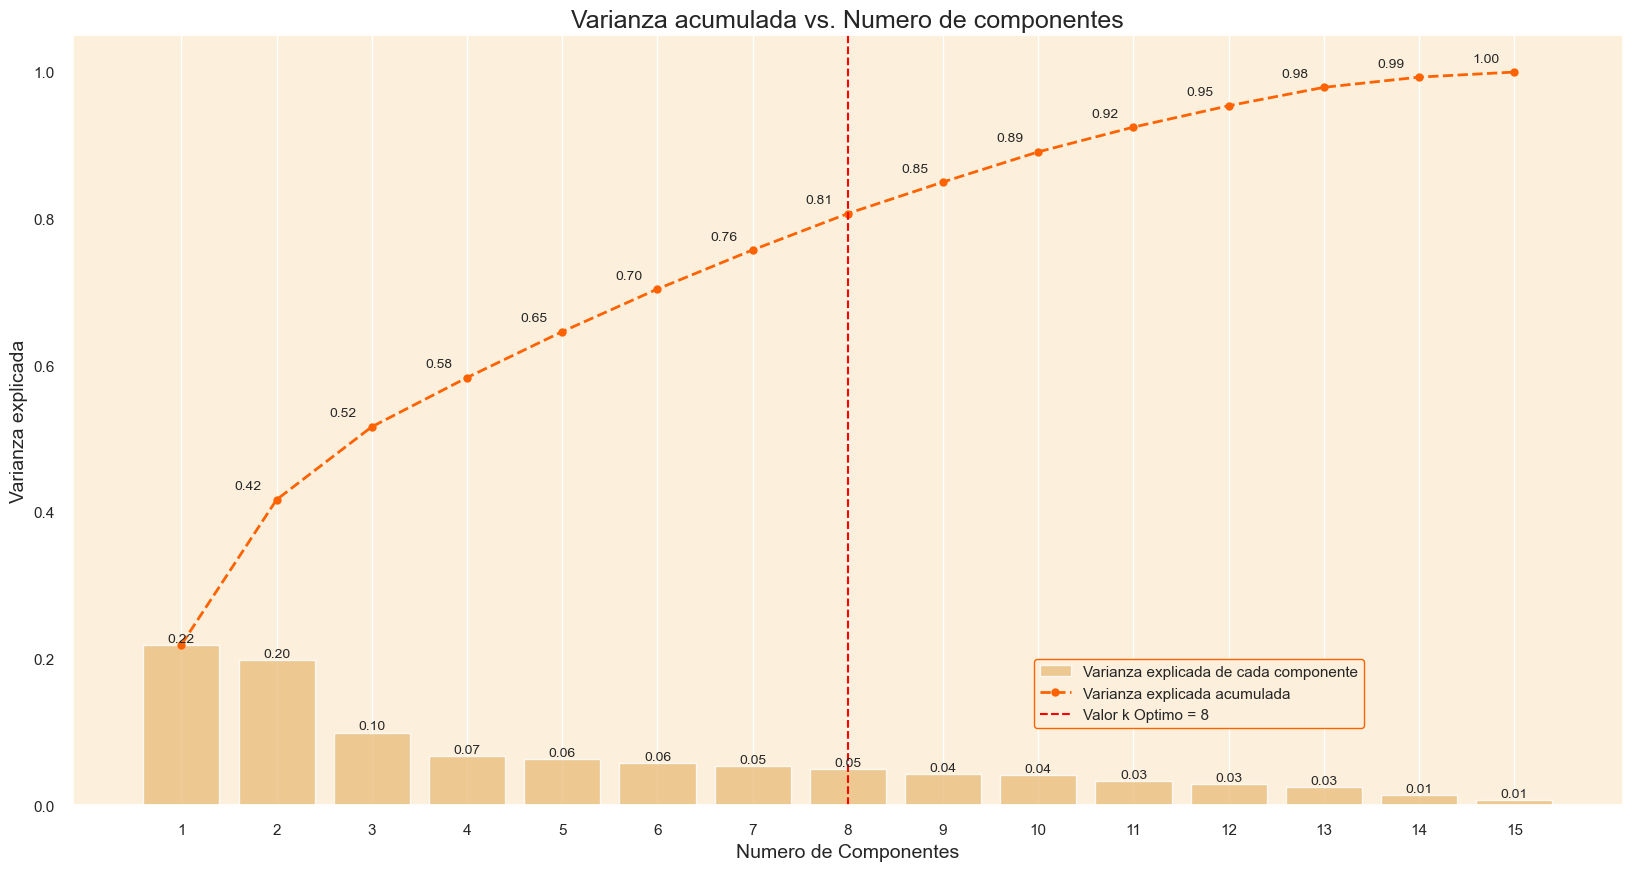

In [217]:

# convertimos CustomerID a índice
datos_clientes_escalado.set_index('CustomerID', inplace=True)

# Aplicamos PCA
pca = PCA().fit(datos_clientes_escalado)


# Calculamos la suma acumulada de la varianza explicada
ratio_varianza_explicada = pca.explained_variance_ratio_
varianza_explicada_acumulada = np.cumsum(ratio_varianza_explicada)

# Configuramos el valor k óptimo

optimal_k = 8

# Configuramos el estilo de la gráfica
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')


plt.figure(figsize=(20, 10))


# Grafico de barras para la varianza explicada de cada componente
barplot = sns.barplot(x=list(range(1, len(varianza_explicada_acumulada) + 1)),
                      y=ratio_varianza_explicada,
                      color='#fcc36d',
                      alpha=0.8)


# linea para la varianza explicada acumulada
lineplot, = plt.plot(range(0, len(varianza_explicada_acumulada)), varianza_explicada_acumulada,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)


# grafico para ver el valor k optimo
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 


# etiquetas y titulo
plt.xlabel('Numero de Componentes', fontsize=14)
plt.ylabel('Varianza explicada', fontsize=14)
plt.title('Varianza acumulada vs. Numero de componentes', fontsize=18)


# Personalizamos las marcas y la leyenda
plt.xticks(range(0, len(varianza_explicada_acumulada)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Varianza explicada de cada componente', 'Varianza explicada acumulada', f'Valor k Optimo = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  


# Muestra los valores de varianza para ambos gráficos en las gráficas
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(ratio_varianza_explicada, varianza_explicada_acumulada)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

Podemos ver que:

* El primer componente explica un 22 % de la varianza
* Los primeros 2 componentes explican un 42% de la varianza
* Los 3 primeros componentes explican un 52% de la varianza

Buscamos el punto en el cual, no interesa añadir otro componente para la cantidad de varianza que explica. (Normalmente es el codo)
En nuestro caso, el codo se encuentra en 3-4, pero en ese punto solo hemos explicado un 65% la varianza.
Por tanto elegiremos 8 componentes, que explica el 81% de la varianza

In [218]:
# Creando un objeto PCA con 6 componentes
pca = PCA(n_components=8)

# Entrenando y transformando los datos originales al nuevo dataframe PCA
datos_cliente_pca = pca.fit_transform(datos_clientes_escalado)

# Creando un nuevo dataframe a partir del dataframe PCA, con columnas etiquetadas PC1, PC2, etc.
datos_cliente_pca = pd.DataFrame(datos_cliente_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Añadiendo el índice CustomerID al nuevo dataframe PCA
datos_cliente_pca.index = datos_clientes_escalado.index

# Mostrando el dataframe resultante basado en los componentes principales
datos_cliente_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
CustomerID,,,,,,,,
12347.0,2.413657,1.828018,-0.817553,-0.168644,-0.221324,0.446623,0.267384,0.374944
12348.0,0.437224,-0.489333,-0.323638,-0.077724,-0.451232,1.958110,1.266355,1.466129
12349.0,0.608537,2.745339,-1.097576,-0.616063,1.137822,-1.557956,-0.408112,0.664940
12350.0,-1.935287,0.204247,-0.189718,-1.521381,-0.351286,0.571491,0.037999,1.075344
12352.0,0.345965,1.623496,2.153973,-0.092225,-0.759599,0.554143,0.206399,0.124453


In [219]:

# Define una función para resaltar los 3 valores absolutos más altos en cada columna de un dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Crear el DataFrame de componentes PCA y aplicar la función de resaltado
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=datos_clientes_escalado.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Dias_ultima_compra,-0.243573,-0.032691,0.038083,-0.380548,0.168804,-0.163898,-0.211904,0.264390
ComprasTotales,0.393124,0.055883,0.064648,0.122882,-0.169284,-0.006291,0.009785,-0.261246
CestaMedia,-0.098303,-0.013262,-0.040544,-0.405923,0.159093,-0.302726,0.760578,-0.348631
ProductosUnicosComprados,0.410990,0.006975,-0.104658,-0.111689,-0.210444,0.085798,-0.021437,-0.196655
media_dias_entre_compras,-0.034135,0.034429,0.052481,0.679724,0.112224,-0.030996,0.492380,0.330119
Dia_Semana,0.125962,-0.987482,0.031134,0.044957,0.039853,-0.058753,0.000839,0.017346
Hour,-0.001250,-0.059498,-0.049235,-0.305281,-0.393182,0.649097,0.350768,0.409304
Media_Gasto_Mensual,0.242879,0.055999,-0.179012,-0.215598,0.349153,-0.246600,-0.001796,0.575670
Desviacion_Gasto_Mensual,0.360469,0.053518,0.010678,0.063865,0.299256,0.097853,0.047949,0.090794
Tendencia_Gasto,-0.010363,0.009569,-0.059730,0.038186,-0.694298,-0.596139,0.020874,0.256384


# K-Means Clustering

## Metodo del codo

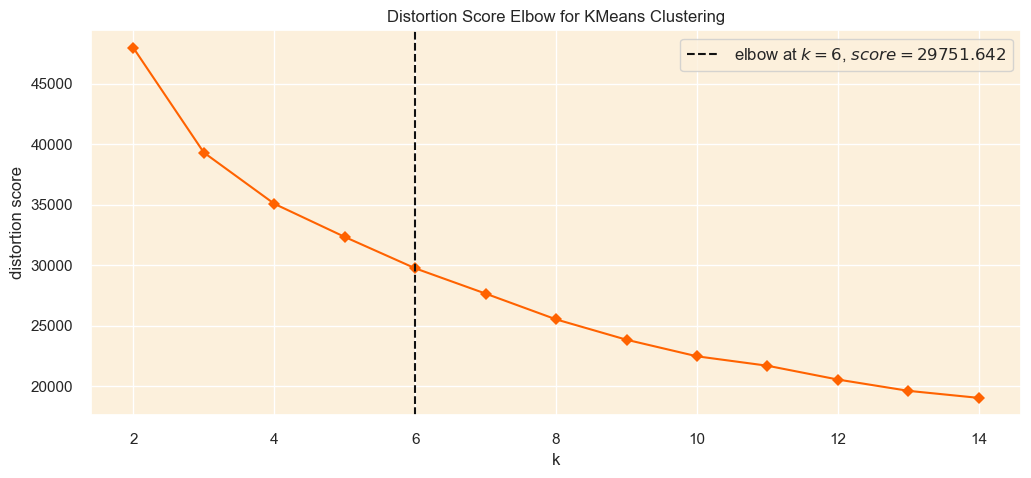

In [220]:

# Configuramos el estilo de la gráfica y el color de fondo
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})


# Colores de la paleta
sns.set_palette(['#ff6200'])


# Instanciamos el modelo de clustering con los parámetros especificados
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=42)


# Creamos una figura y un eje con el tamaño deseado
fig, ax = plt.subplots(figsize=(12, 5))


# Instanciamos el visualizador con el modelo y el rango de valores k, y deshabilitamos la gráfica de tiempo
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)


# Entrenamos el modelo con el dataframe PCA
visualizer.fit(datos_cliente_pca)

# Mostramos el gráfico
visualizer.show();

El número de clusters optimo según la liberaria es 6. Podriamos decir que esta entre 3 y 8. Vamos a usar el metodo de la silueta para decidir entre estos valores. Mi opción iría por 4 pero hagamos el otro método

In [221]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Realiza un análisis de Silhouette para un rango de valores k y visualiza los resultados.
    """

    
    # Configuramos el tamaño de la figura
    plt.figure(figsize=figsize)

   
    # Create una cuadrícula con (stop_k - start_k + 1) filas y 2 columnas
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

  
    # Asignamos el primer gráfico a la primera fila y ambas columnas
    first_plot = plt.subplot(grid[0, :])

   
    # Primer gráfico: Puntuaciones de Silhouette para diferentes valores de k
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    
    # Itera entre el rango de valores k
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    
    # Añade el texto del valor k óptimo a la gráfica
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

   
    # Segundo gráfico (subplot): Gráficos de Silhouette para cada valor k
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

       
        # Asignamos los gráficos a la segunda, tercera y cuarta filas
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

       
        # Añadimos el texto de la puntuación de Silhouette a la gráfica
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

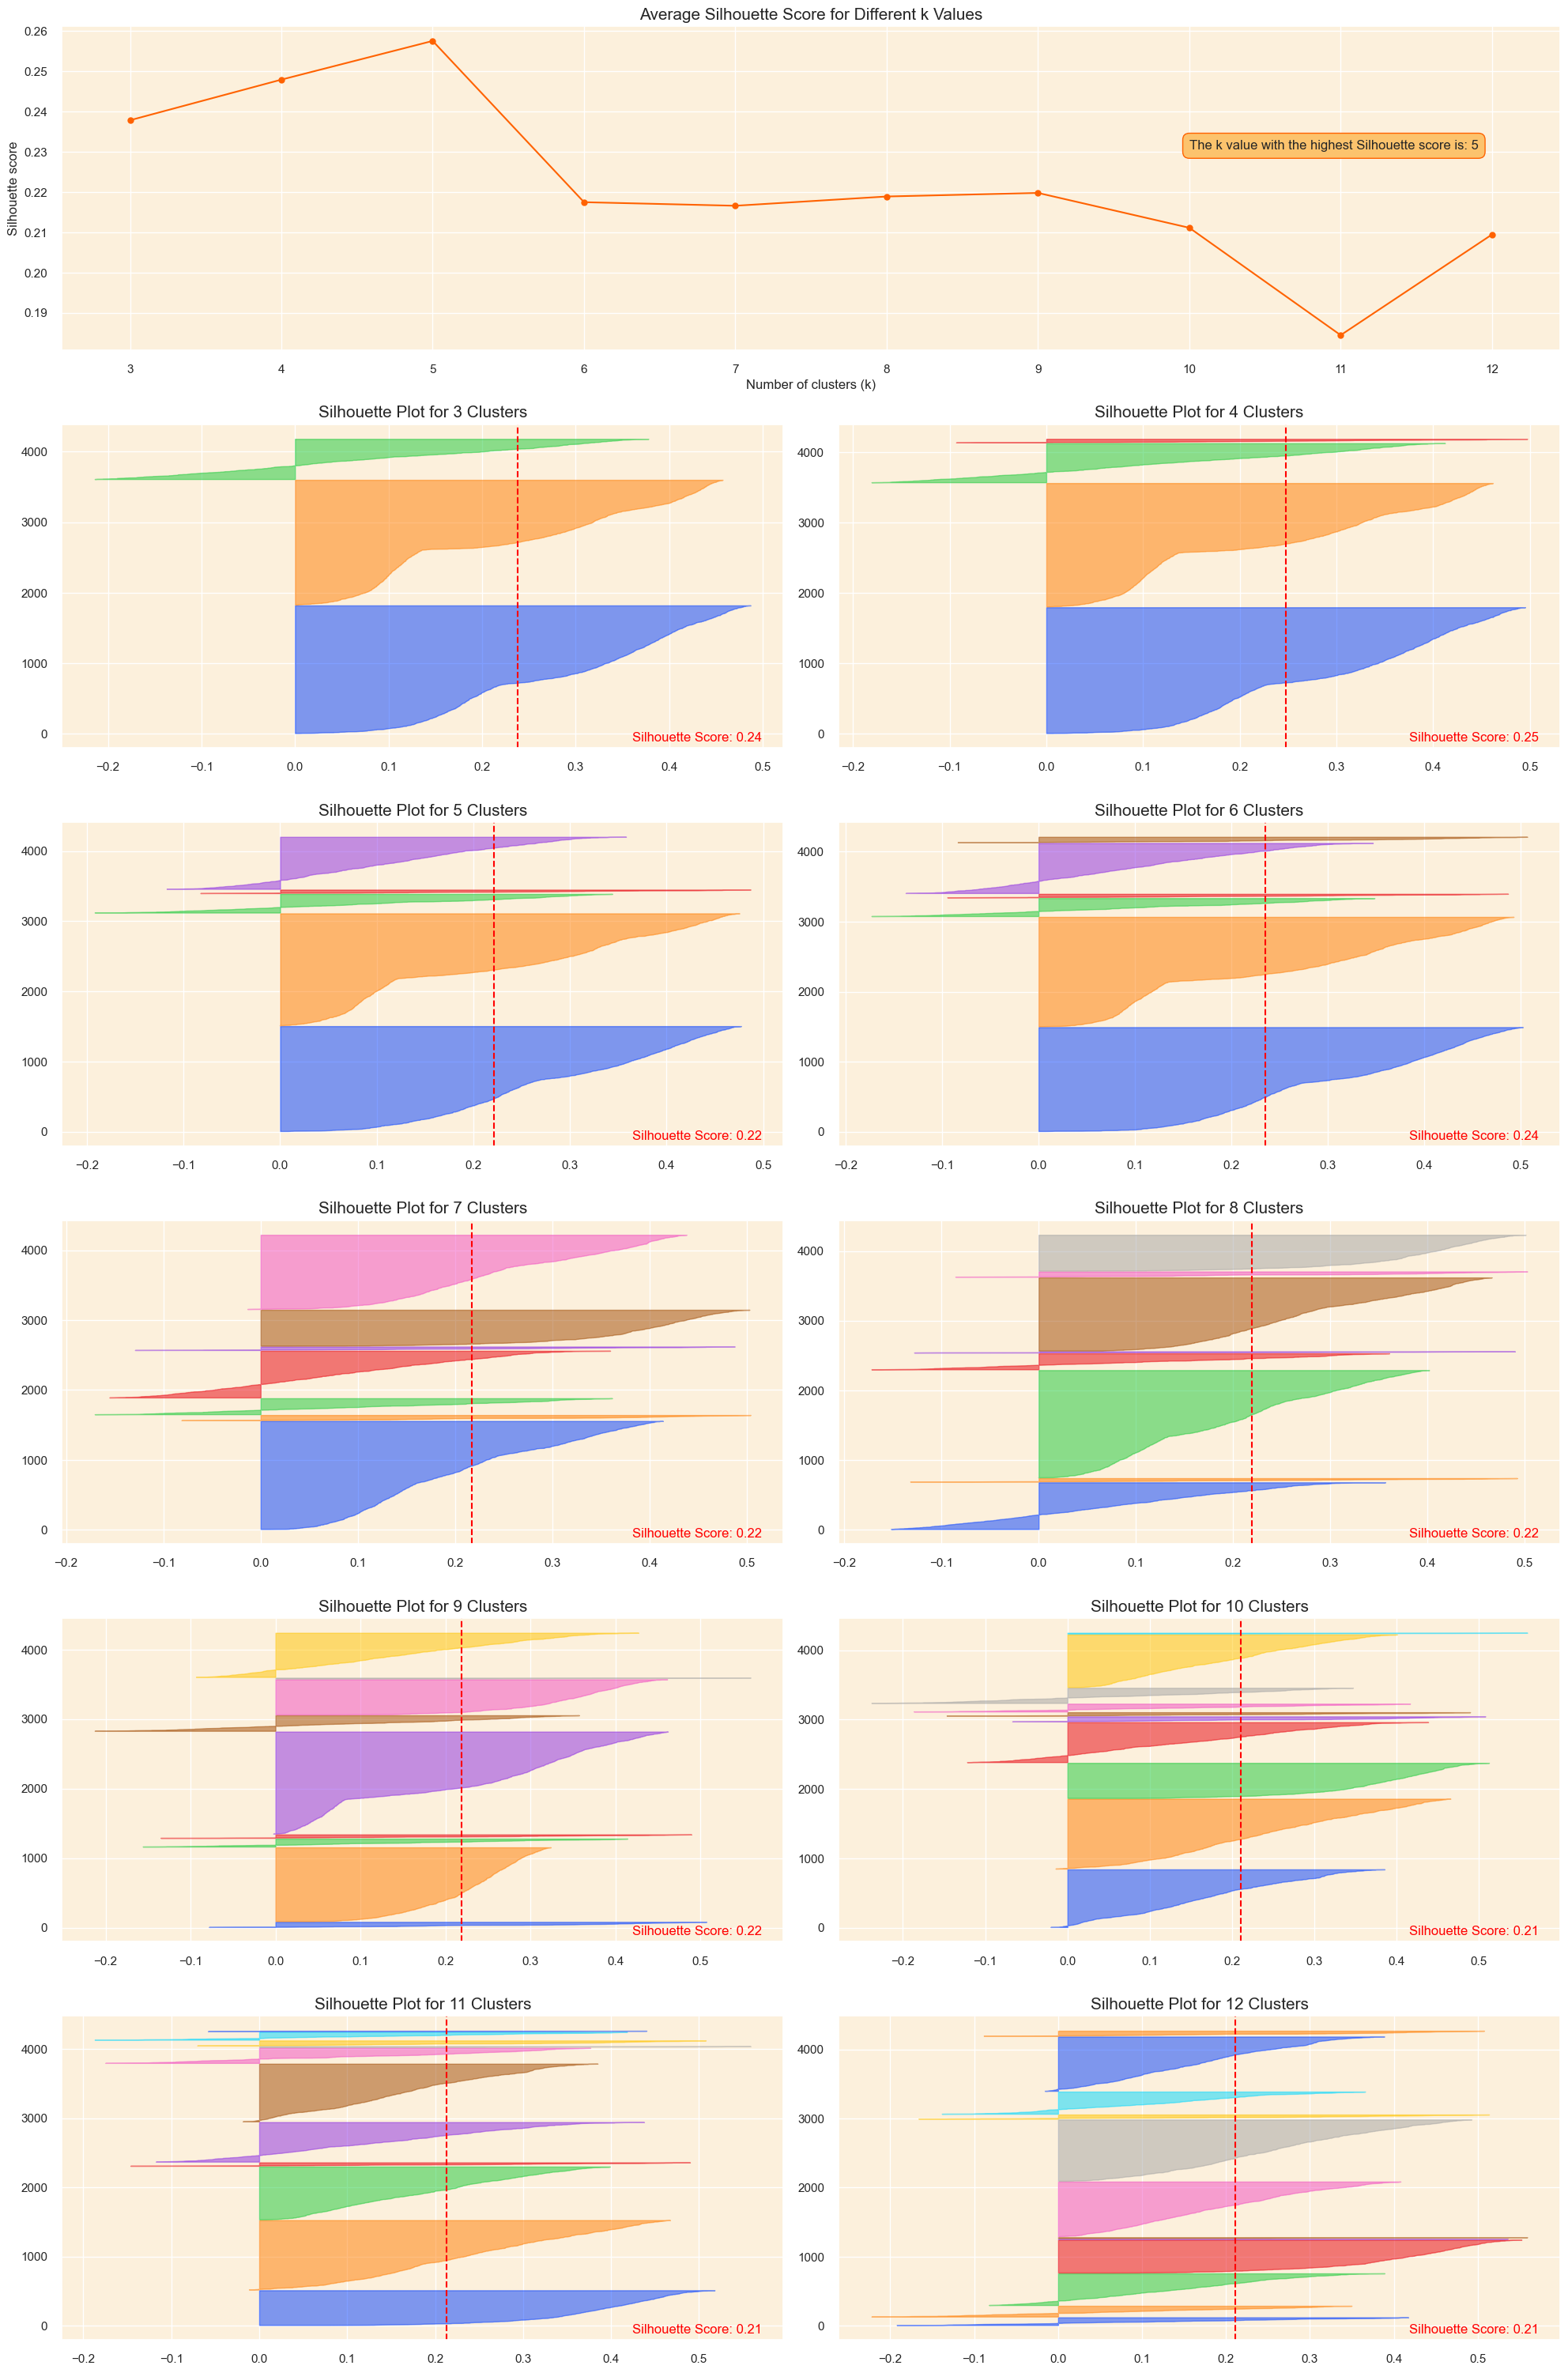

In [222]:
silhouette_analysis(datos_cliente_pca, 3, 12, figsize=(20, 50))

Finalmente elegiremos 4 Clusters

# Aplicamos K-Means

In [223]:
# Aplicamos el clustering KMeans usando el valor k óptimo
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans.fit(datos_cliente_pca)

# Obtener la frecuencia de cada cluster
cluster_frequencies = Counter(kmeans.labels_)

# Crear un mapeo de las etiquetas antiguas a las nuevas etiquetas basadas en la frecuencia
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Aplicar el mapeo para obtener las nuevas etiquetas
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Añadir las nuevas etiquetas de cluster al conjunto de datos original
datos_clientes_limpio['cluster'] = new_labels

# Añadir las nuevas etiquetas de cluster a la versión PCA del conjunto de datos
datos_cliente_pca['cluster'] = new_labels


In [224]:
datos_clientes_limpio.head()

,CustomerID,Dias_ultima_compra,ComprasTotales,CestaMedia,ProductosUnicosComprados,media_dias_entre_compras,Dia_Semana,Hour,Media_Gasto_Mensual,Desviacion_Gasto_Mensual,Tendencia_Gasto,ClientTotalSales,ClientTotalCancel,ClientTotalSales_uf,ClientTotalCancel_uf,ClientCancelRatio_uf,cluster
0,12347.0,2,7,770.172857,103,2.016575,1,14,615.714286,341.070789,4.486071,134181.24,0.00,2458.0,0.0,0.000000,2
1,12348.0,75,4,1347.802500,21,10.884615,3,19,359.310000,203.875689,-100.884000,17510.00,0.00,2332.0,0.0,0.000000,1
2,12349.0,18,1,5391.210000,72,0.000000,0,9,1457.550000,0.000000,0.000000,126543.60,0.00,630.0,0.0,0.000000,0
3,12350.0,310,1,5391.210000,16,0.000000,2,16,294.400000,0.000000,0.000000,5350.40,0.00,196.0,0.0,0.000000,0
4,12352.0,36,8,673.901250,57,3.132530,1,14,316.352500,134.700629,9.351000,21041.24,842.31,526.0,63.0,11.977186,0


# Evaluación del Cluster

Esto tengo que traducirlo y corregirlo

In [225]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff', '#ffba08']  # Añadido un cuarto color

# Create separate data frames for each cluster
cluster_0 = datos_cliente_pca[datos_cliente_pca['cluster'] == 0]
cluster_1 = datos_cliente_pca[datos_cliente_pca['cluster'] == 1]
cluster_2 = datos_cliente_pca[datos_cliente_pca['cluster'] == 2]
cluster_3 = datos_cliente_pca[datos_cliente_pca['cluster'] == 3]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
fig.add_trace(go.Scatter3d(x=cluster_3['PC1'], y=cluster_3['PC2'], z=cluster_3['PC3'], 
                           mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4), name='Cluster 3'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()


Veamos el porcentaje de cada cluster

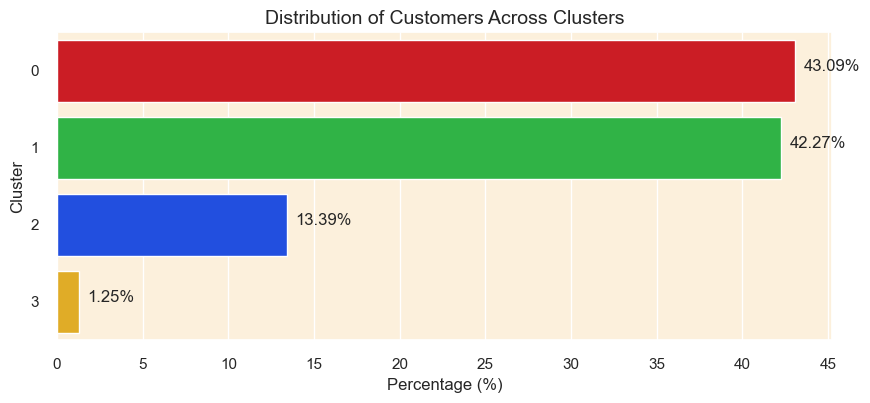

In [226]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (datos_cliente_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

Veamos las metricas de evaluacion

In [228]:
# Compute number of customers
num_observations = len(datos_cliente_pca)

# Separate the features and the cluster labels
X = datos_cliente_pca.drop('cluster', axis=1)
clusters = datos_cliente_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4152         |
|    Silhouette Score     | 0.24789370092622057 |
| Calinski Harabasz Score |  919.0151286148782  |
|  Davies Bouldin Score   | 1.2375129317748144  |
+-------------------------+---------------------+


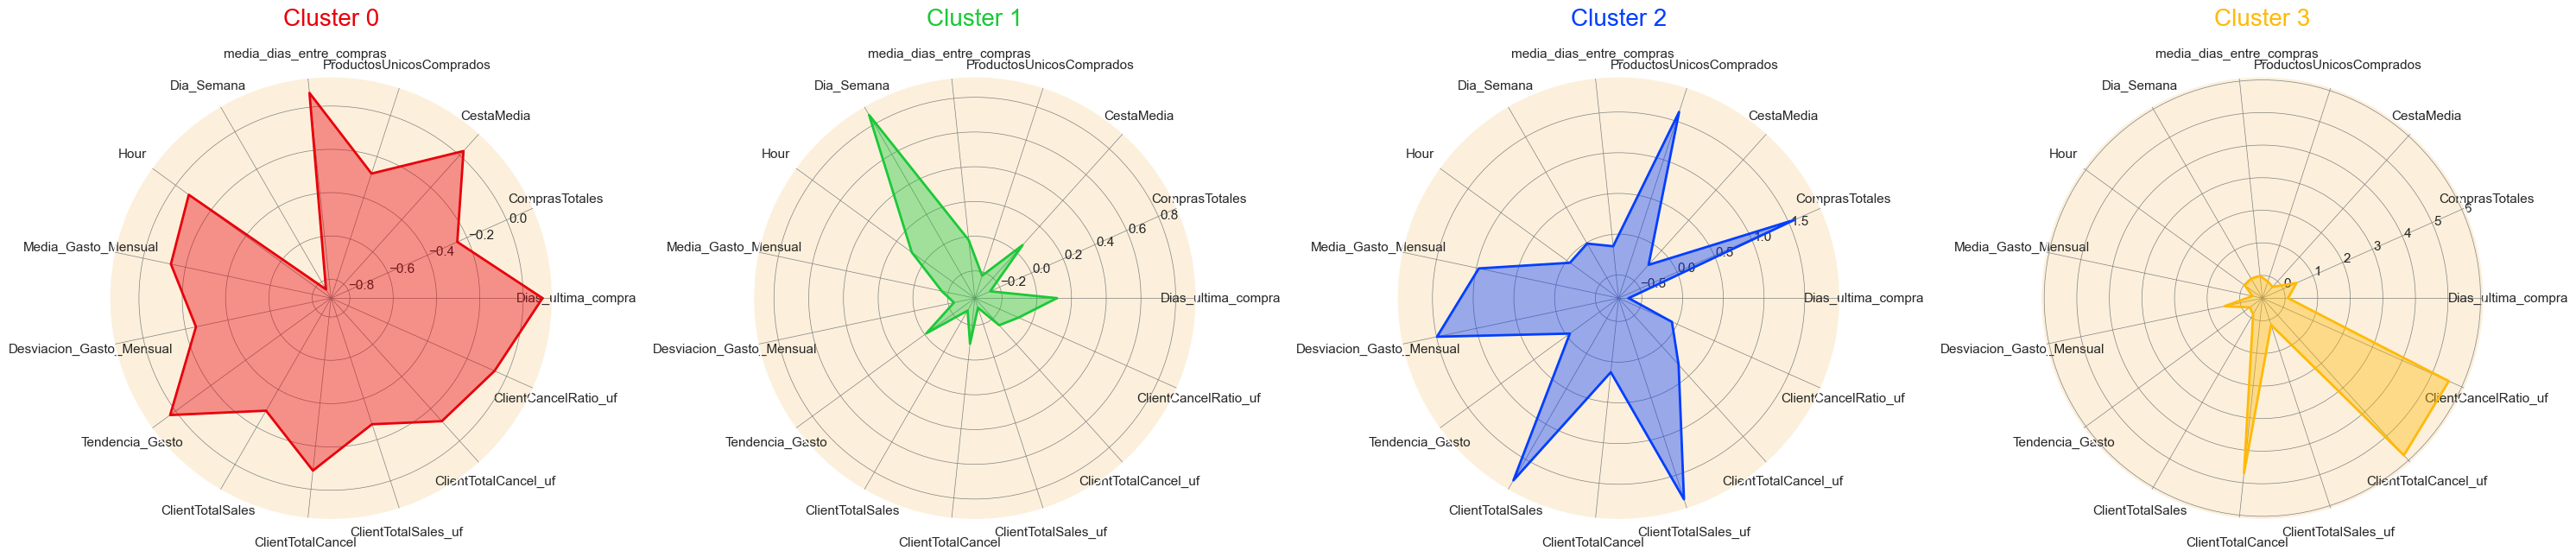

In [233]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = datos_clientes_limpio.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Calculamos el número de clusters
num_clusters = len(df_customer['cluster'].unique())

# Initialize the figure with the correct number of subplots
fig, axs = plt.subplots(figsize=(30, 20), subplot_kw=dict(polar=True), nrows=1, ncols=num_clusters)

# Hacemos que axs sea siempre una lista para manejar el caso de un solo cluster
if num_clusters == 1:
    axs = [axs]

# Create radar chart for each cluster
for i in range(num_clusters):
    ax = axs[i]
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax, angles, data, colors[i], i)

    # Add input data
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels[:-1])

    # Add a grid
    ax.grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

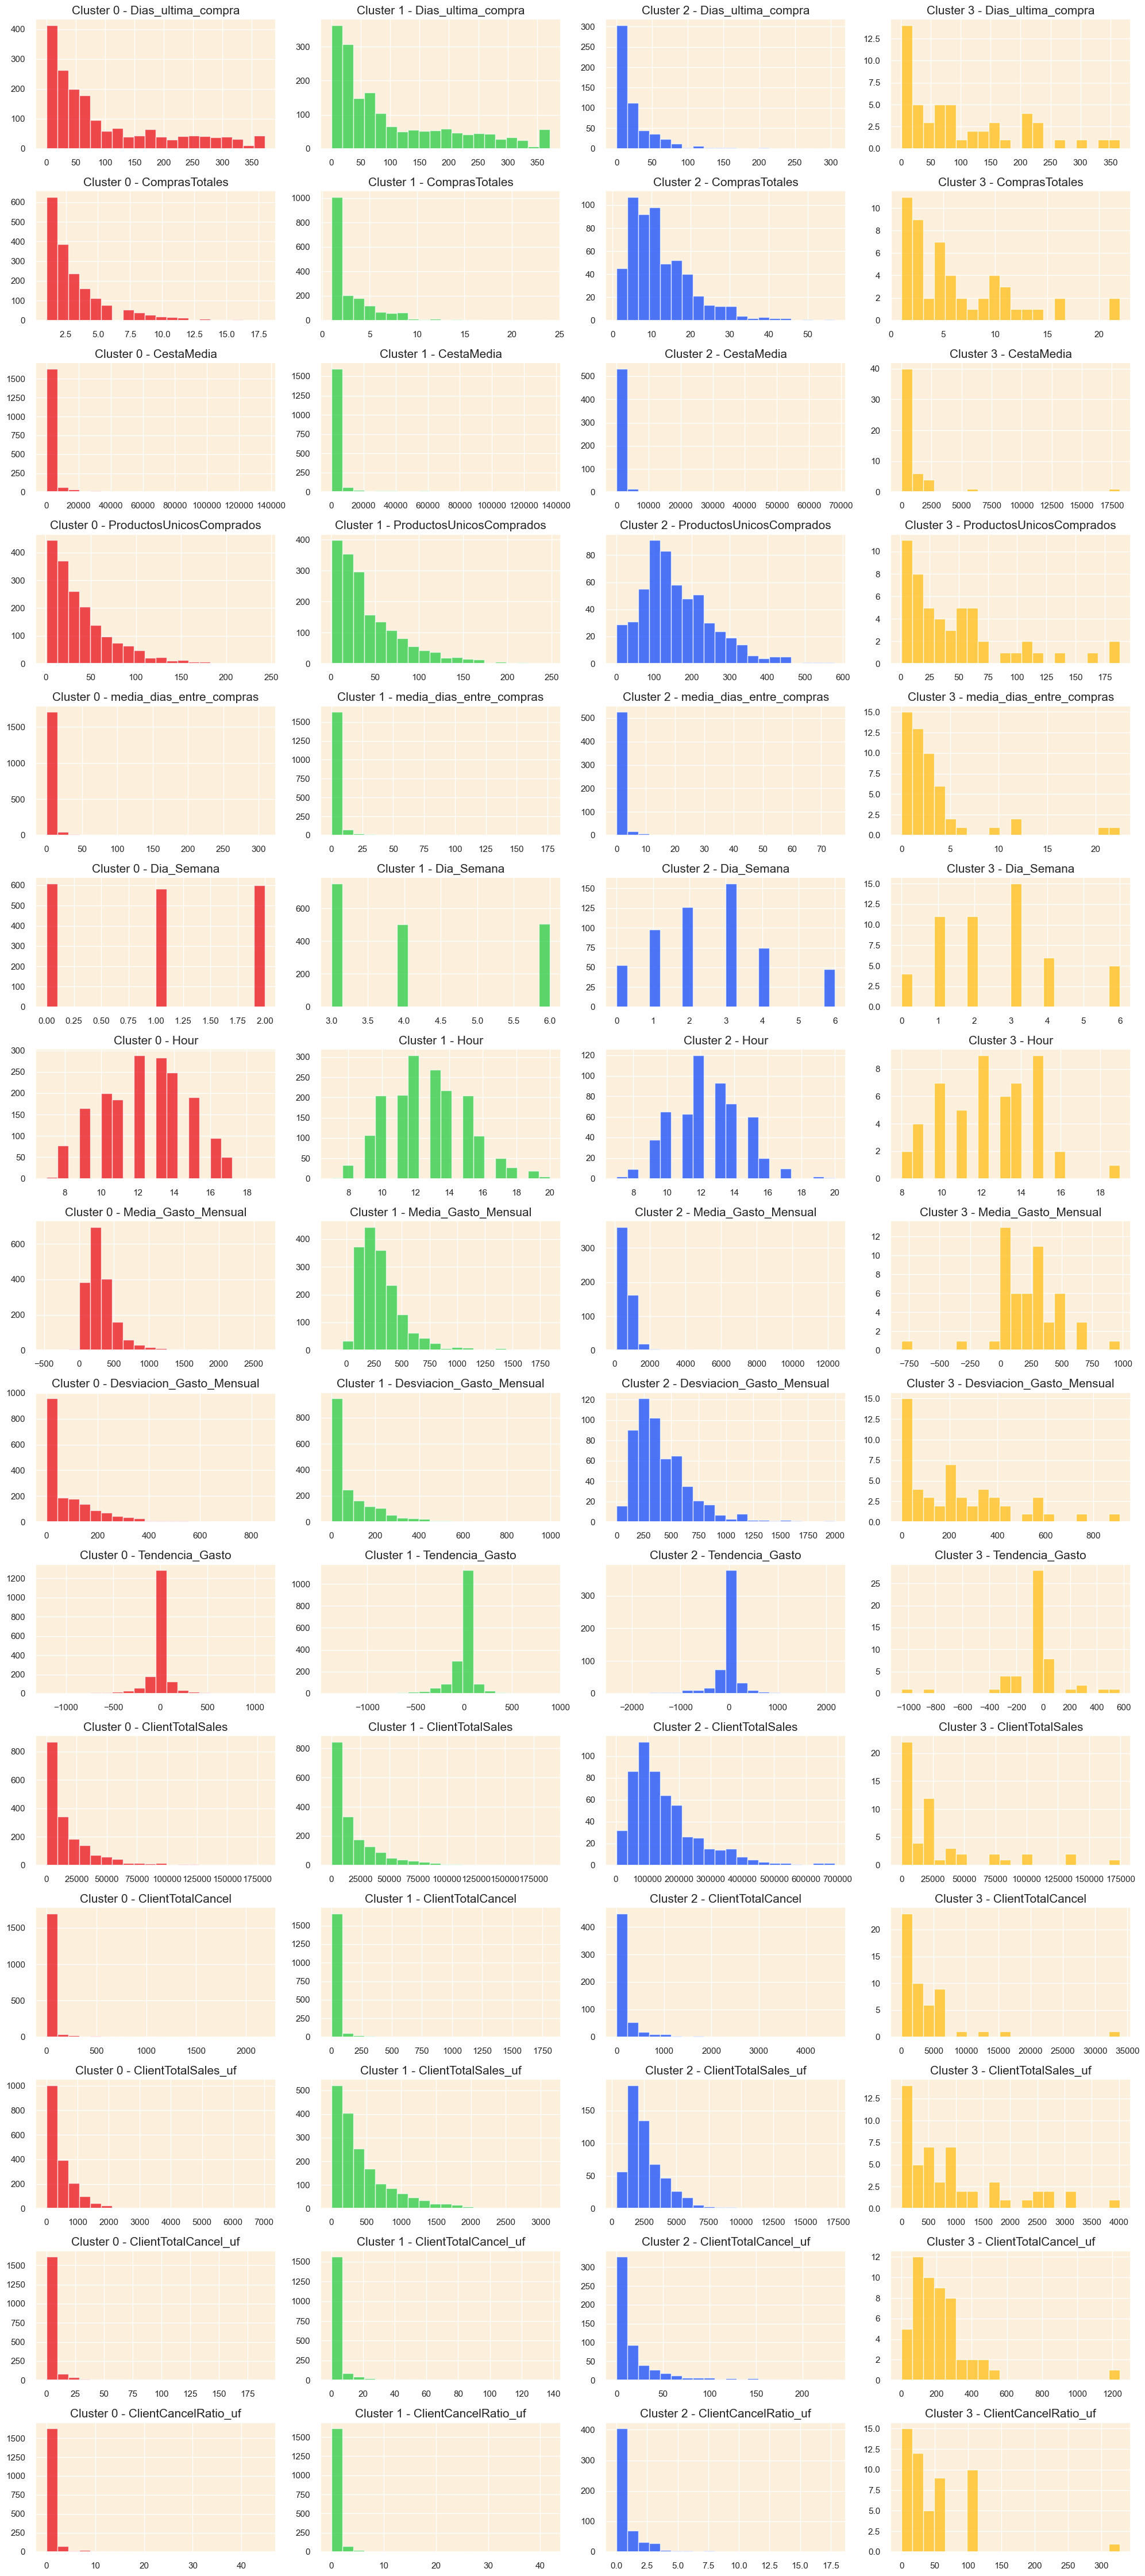

In [234]:
# Plot histograms for each feature segmented by the clusters
features = datos_clientes_limpio.columns[1:-1]
clusters = datos_clientes_limpio['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = datos_clientes_limpio[datos_clientes_limpio['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

* Cluster 0:

* Compran a principio de semana
* Pasa bastante tiempo entre compras
* Tienen una diversidad de productos moderada
* Su cesta media es alta
* Compras totales moderadas
* Hace bastante tiempo desde su ultima compra
* Tienen un ratio de cancelacion moderado
* Tiene una tendencia al gasto alta (Creciendo)

* Cluster 1:

* Compran los fines de semana
* Compran a menudo
* Tienen poca diversidad
* Su cesta media es baja
* Tienen pocas compras totales
* Ha pasado poco tiempo desde su ultima compra
* Tienen una tasa baja de cancelaciones
* Tienen una tendencia baja al gasto (Esta decreciendo)

* Cluster 2: 

* Compran a principio de semana
* Pasa poco tiempo entre compras
* Tienen alta diversidad de productos
* El valor medio de la cesta es bajo
* Tienen muchas compras individuales
* Hace poco tiempo desde su ultima compra
* Su ratio de cancelaciones es bajo
* Compran muchas unidades de producto
* Tienen una tendencia al gasto baja (Esta decreciendo)
* Tienen un gasto medio mensual moderado, con una desviacion alta entre compras

* Cluster 3:

* Compran a principio de semana
* Han comprado poco
* Tienen una alta tasa de cancelaciones
* Es el grupo con mas cancelaciones


Sistema de recomendacion de FARZAD, pendiente de modificar y usar un modelo nuevo

In [236]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = datos_outliers['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Paso 1.1: Aseguramos que la columna 'CustomerID' sea del mismo tipo en ambos DataFrames
df_filtered['CustomerID'] = df_filtered['CustomerID'].astype('float')

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
datos_clientes_limpio['CustomerID'] = datos_clientes_limpio['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(datos_clientes_limpio[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = datos_clientes_limpio[datos_clientes_limpio['cluster'] == cluster]['CustomerID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = datos_clientes_limpio.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [237]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
16928.0,22616,pack of 12 london tissues,21212,pack of 72 retrospot cake cases,84077,world war 2 gliders asstd designs
15746.0,84879,assorted colour bird ornament,85123A,white hanging heart t-light holder,15036,assorted colours silk fan
15844.0,84077,world war 2 gliders asstd designs,84879,assorted colour bird ornament,85099B,jumbo bag red retrospot
16554.0,84077,world war 2 gliders asstd designs,85123A,white hanging heart t-light holder,15036,assorted colours silk fan
17274.0,84077,world war 2 gliders asstd designs,84879,assorted colour bird ornament,85123A,white hanging heart t-light holder
12492.0,84077,world war 2 gliders asstd designs,84879,assorted colour bird ornament,85123A,white hanging heart t-light holder
14772.0,84077,world war 2 gliders asstd designs,84879,assorted colour bird ornament,85123A,white hanging heart t-light holder
15720.0,84077,world war 2 gliders asstd designs,85099B,jumbo bag red retrospot,17003,brocade ring purse
16566.0,84077,world war 2 gliders asstd designs,84879,assorted colour bird ornament,85123A,white hanging heart t-light holder
